<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase1/Experiments/Transformer/Transformer_4_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets -q

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import datasets
from datasets import load_dataset
from transformers import BertTokenizerFast, TFAutoModel
from tensorflow.keras.preprocessing.sequence import pad_sequences


import gc

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(rand_seed)
    tf.random.set_seed(seed) # tensorflow

rand_seed = 99
seed_everything(rand_seed)

### -----------\\//------------ ###

def LabelEncoding(x):
    if x == -1:
        # return 2
        return [0,0,1]
    if x == 0:
        # return 0
        return [1,0,0]
    if x == 1:
        # return 1
        return [0,1,0]

nepCov19 = load_dataset("raygx/NepCov19TweetsPlus").shuffle(rand_seed)['train']
# nepCov19 = datasets.concatenate_datasets([load_dataset("raygx/NepCov19TweetsPlus").shuffle(rand_seed)['train'],load_dataset('raygx/CORONA_en2np').shuffle(rand_seed)['train']])

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# nepCov19 = datasets.concatenate_datasets([nepCov19.filter(lambda x: x['Sentiment']==-1).select(range(12000)), nepCov19.filter(lambda x: x['Sentiment']==0).select(range(12000)), nepCov19.filter(lambda x: x['Sentiment']==1).select(range(12000))])
nepCov19

Dataset({
    features: ['Sentiment', 'Sentences'],
    num_rows: 41541
})

In [4]:
max_len = 128
tokenizer = BertTokenizerFast.from_pretrained("Shushant/nepaliBERT")
print("Vocab Size",len(tokenizer))

nepCov19 = nepCov19.shuffle(rand_seed).train_test_split(test_size=0.2)
print("Dataset",nepCov19)
train_input = pad_sequences(
                        tokenizer(
                            nepCov19['train']['Sentences']
                            ).input_ids,
                        maxlen = max_len,
                        padding='post',
                        value=tokenizer.pad_token_id
                    )
train_labels = [LabelEncoding(x) for x in nepCov19['train']['Sentiment']]

test_input = pad_sequences(
                        tokenizer(
                            nepCov19['test']['Sentences']
                            ).input_ids,
                        maxlen = max_len,
                        padding='post',
                        value=tokenizer.pad_token_id
                    )
test_labels = [LabelEncoding(x) for x in nepCov19['test']['Sentiment']]


Vocab Size 30522
Dataset DatasetDict({
    train: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 8309
    })
})


In [5]:
# hf_model = TFAutoModel.from_pretrained('Shushant/nepaliBERT',from_pt=True)
# hf_model.bert.embeddings.get_weights()[0]

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

'''
    merge: 'interleave' or 'concat' or 'add' or None : defaults: 'interleave'
        -> when 'concat' combines [sin,sin,...,cos,cos,...]
        -> when 'interleave' combines [sin,cos,sin,cos......]
        -> when 'add' it adds 'interleave' and 'concat'
'''
def PositionalEncoding(seq_length=2048,feature_depth=512,merge='interleave'):
      depth = feature_depth/2
      length = seq_length

      positions = np.arange(length)[:, np.newaxis]      # (seq, 1)
      depths = np.arange(depth)[np.newaxis, :]/depth    # (1, depth)

      angle_rates = 1 / (10000**depths)                 # (1, depth)
      angle_rads = positions * angle_rates + 0.0001     # (pos, depth)

      sin = np.sin(angle_rads)
      cos = np.cos(angle_rads)
      pos_encoding = np.concatenate([sin, cos], axis=-1)

      ipos_encoding = np.zeros(pos_encoding.shape)
      ipos_encoding[:, ::2] = sin
      ipos_encoding[:, 1::2] = cos
      if merge=='concat':
            return tf.cast(pos_encoding, dtype=tf.float32)
            print("Concatanation",str(pos_encoding[:2]),pos_encoding.shape)
      elif merge=='add':
            return tf.cast((pos_encoding+ipos_encoding)/2, dtype=tf.float32)
      else:
            return tf.cast(ipos_encoding, dtype=tf.float32)
            print("Interleaving",str(ipos_encoding[:2]),ipos_encoding.shape)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model, context_length=2048,pos_enc_merge='add'):
    super().__init__()
    self._name='PosEmbd'
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model,
                                              #  embeddings_initializer=tf.keras.initializers.Constant(hf_model.bert.embeddings.get_weights()[0][:,:d_model]),
                                               mask_zero=True)
    self.pos_encoding = PositionalEncoding(seq_length=context_length, feature_depth=d_model,merge=pos_enc_merge)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [7]:
##------------
##------Attention----------------
##----------------------

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def build(self,input_shape):
    self.mha._build_from_signature(tf.TensorShape(input_shape),tf.TensorShape(input_shape),tf.TensorShape(input_shape))

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output,self.attention_score = self.mha(
        query=x,
        value=x,
        key=x, return_attention_scores=True)

    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class LocalizedSelfAttention(BaseAttention):
  def __init__(self, num_window=8,**kwargs):
    super().__init__(**kwargs)
    self._name='Local_Self_Attention'
    self.num_window = num_window
    self.concat_layer = tf.keras.layers.Concatenate(axis=1)

  def call(self, x):
    attention_output = []
    self.attention_score = []
    for t in tf.split(x,num_or_size_splits=self.num_window,axis=1):
      aout, ascore = self.mha(key=t,query=t,value=t,return_attention_scores=True)
      attention_output.append(aout)
      self.attention_score.append(ascore)

    attention_output = self.concat_layer(attention_output)
    x = self.add([x, attention_output])
    x = self.layernorm(x)
    return x


In [8]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [9]:
##-------
##------Encoder----------------
##----------------------

class LSA_EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model,num_window, dff, num_heads=2,dropout_rate=0.1):
    super().__init__()

    self._name='Local_Self_Attention_Encoder'
    self.self_attention = LocalizedSelfAttention(
        num_window=num_window,
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class GSA_EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self._name='Global_Self_Attention_Encoder'
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

"""_summary_

  attn_stack_type: defines how to arrange LSA and GSA; defaults to 'add' [(LSA+GSA),...];
                    another option is 'stack': one after another [GSA,LSA,.....,GSA+LSA]
"""
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, GSA_num_heads,LSA_num_window,LSA_num_heads,dff,attn_stack_type='add', dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers if num_layers else 1
    self.attn_stack_type = attn_stack_type ##By Default Add
    if self.attn_stack_type not in ['add','stack']:
      self.attn_stack_type = 'add'

    self.lsa_enc_layers = [
                            LSA_EncoderLayer(d_model=d_model,
                                num_window=LSA_num_window,
                                num_heads=LSA_num_heads,
                                dff=dff,
                                dropout_rate=dropout_rate)
                            for _ in range(num_layers)
                        ]
    self.gsa_enc_layers = [
                            GSA_EncoderLayer(d_model=d_model,
                                num_heads=GSA_num_heads,
                                dff=dff,
                                dropout_rate=dropout_rate)
                            for _ in range(num_layers)
                        ]

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    if self.attn_stack_type == 'add':
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    if self.attn_stack_type == 'add':
      for i in range(self.num_layers):
          x = self.layer_norm(self.add([self.lsa_enc_layers[i](x),self.gsa_enc_layers[i](x)]))

    if self.attn_stack_type == 'stack':
      for i in range(self.num_layers):
        x = self.lsa_enc_layers[i](
              self.gsa_enc_layers[i](x)
            )

    return self.dropout(x)



In [10]:
class Transformer(tf.keras.models.Model):
  def __init__(self, *, num_layers, d_model, GSA_num_heads,LSA_num_window,LSA_num_heads,
               dff, vocab_size,num_class=2,attn_stack_type='add', dropout_rate=0.1):
    super().__init__()
    self._name = 'Fusion'
    if not dff:
      dff = d_model * 2 ## default value for dff

    self.d_model = d_model
    self.num_layers = num_layers if num_layers else 1

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.encoder = Encoder(num_layers=num_layers,d_model=d_model,GSA_num_heads=GSA_num_heads,
                           LSA_num_window=LSA_num_window,LSA_num_heads=LSA_num_heads,
                           dff=dff,attn_stack_type=attn_stack_type,dropout_rate=dropout_rate)

    self.flatten = tf.keras.layers.Flatten()
    self.out = tf.keras.layers.Dense(d_model,activation='gelu',name='feature')
    self.head = tf.keras.layers.Dense(num_class,activation='softmax',name='classification_head')

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    x = self.encoder(x) # Shape `(batch_size, seq_len, d_model)`.
    self.last_hidden_state = x
    self.pooled_state = self.out(self.flatten(x))
    # self.pooled_state = tf.reduce_logsumexp(x,axis=1) * 0.1 # Shape `(batch_size, d_model)`.
    return self.head(self.pooled_state)  # Shape `(batch_size, num_class)`.

In [11]:
model = Transformer(num_layers=1,d_model=32,GSA_num_heads=8,
                    LSA_num_heads=4,LSA_num_window=8,dff=128,
                    vocab_size=len(tokenizer),num_class=3, attn_stack_type='add')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,weight_decay=0.001),
    loss='categorical_crossentropy',
    metrics=['acc'])

batch_size = 32
dummy = np.ones((batch_size,max_len))
model(dummy) ## building the model
model.summary()

Model: "Fusion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 PosEmbd (PositionalEmbeddin  multiple                 976704    
 g)                                                              
                                                                 
 encoder (Encoder)           multiple                  67392     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 feature (Dense)             multiple                  131104    
                                                                 
 classification_head (Dense)  multiple                 99        
                                                                 
Total params: 1,175,299
Trainable params: 1,175,299
Non-trainable params: 0
__________________________________________________

In [12]:
history = model.fit(tf.constant(train_input),
        tf.constant(train_labels),
        epochs=30,batch_size=batch_size,
        validation_data=[tf.constant(test_input),tf.constant(test_labels)],
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=3,
                            verbose=1, mode='auto',
                            restore_best_weights=True)
                        ])

Epoch 1/30
1039/1039 [==============================] - 166s 142ms/step - loss: 1.1300 - acc: 0.3453 - val_loss: 1.0954 - val_acc: 0.3678
Epoch 2/30
1039/1039 [==============================] - 30s 29ms/step - loss: 1.0995 - acc: 0.3557 - val_loss: 1.0945 - val_acc: 0.3636
Epoch 3/30
1039/1039 [==============================] - 25s 24ms/step - loss: 1.0961 - acc: 0.3620 - val_loss: 1.0911 - val_acc: 0.3820
Epoch 4/30
1039/1039 [==============================] - 25s 24ms/step - loss: 1.0918 - acc: 0.3791 - val_loss: 1.0884 - val_acc: 0.3890
Epoch 5/30
1039/1039 [==============================] - 24s 23ms/step - loss: 1.0877 - acc: 0.3885 - val_loss: 1.0818 - val_acc: 0.4179
Epoch 6/30
1039/1039 [==============================] - 26s 25ms/step - loss: 1.0812 - acc: 0.4020 - val_loss: 1.0720 - val_acc: 0.4285
Epoch 7/30
1039/1039 [==============================] - 23s 22ms/step - loss: 1.0687 - acc: 0.4296 - val_loss: 1.0617 - val_acc: 0.4358
Epoch 8/30
1039/1039 [========================

<Axes: >

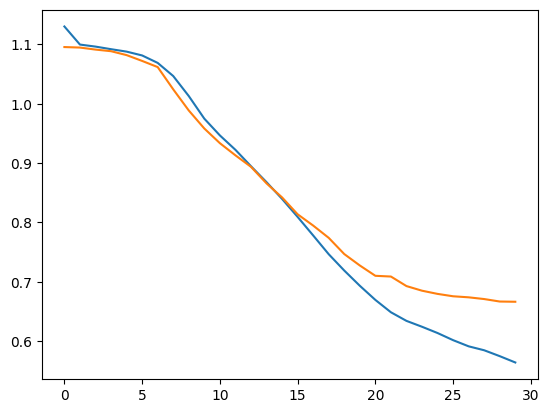

In [18]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

Epoch 1/30
1039/1039 [==============================] - 36s 35ms/step - loss: 0.5592 - acc: 0.7697 - val_loss: 0.6668 - val_acc: 0.7146
Epoch 2/30
1039/1039 [==============================] - 24s 23ms/step - loss: 0.5485 - acc: 0.7713 - val_loss: 0.6607 - val_acc: 0.7160
Epoch 3/30
1039/1039 [==============================] - 23s 22ms/step - loss: 0.5421 - acc: 0.7758 - val_loss: 0.6590 - val_acc: 0.7189
Epoch 4/30
1039/1039 [==============================] - 25s 24ms/step - loss: 0.5353 - acc: 0.7785 - val_loss: 0.6513 - val_acc: 0.7193
Epoch 5/30
1039/1039 [==============================] - 23s 22ms/step - loss: 0.5274 - acc: 0.7836 - val_loss: 0.6568 - val_acc: 0.7225
Epoch 6/30
1039/1039 [==============================] - 24s 23ms/step - loss: 0.5184 - acc: 0.7875 - val_loss: 0.6598 - val_acc: 0.7215
Epoch 7/30
1039/1039 [==============================] - 24s 23ms/step - loss: 0.5124 - acc: 0.7914 - val_loss: 0.6574 - val_acc: 0.7234
Epoch 7: early stopping


<Axes: >

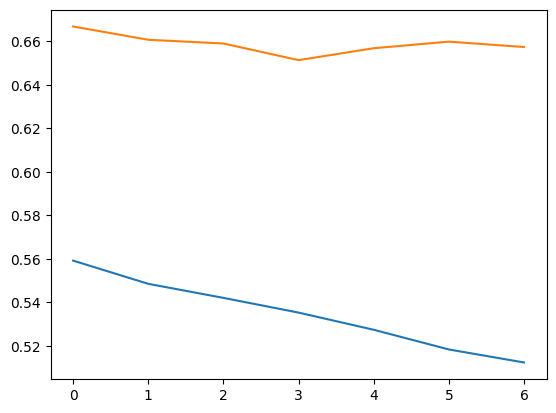

In [20]:
history = model.fit(tf.constant(train_input),
        tf.constant(train_labels),
        epochs=30,batch_size=batch_size,
        validation_data=[tf.constant(test_input),tf.constant(test_labels)],
        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', patience=3,
                            verbose=1, mode='auto',
                            restore_best_weights=True)
                        ])


seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

In [21]:
####-----------------------------------------
## ---------------Prediction------------------
####-----------------------------------------

pred_labels = [np.argmax(x) for x in
            model.predict(
                x=tf.constant(test_input)
            )
    ]

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
eval_labels = [np.argmax(x) for x in test_labels]


260/260 [==============================] - 3s 10ms/step


F1-Score 0.7204071943404233
Precision-Score 0.730842828111468
Recall-Score 0.7193404741846191
Accuracy-Score 0.7193404741846191
tf.Tensor(
[[1750  547  332]
 [ 183 2301  512]
 [ 144  614 1926]], shape=(3, 3), dtype=int32)
True Labels Onlys tf.Tensor(
[[2629    0    0]
 [   0 2996    0]
 [   0    0 2684]], shape=(3, 3), dtype=int32)


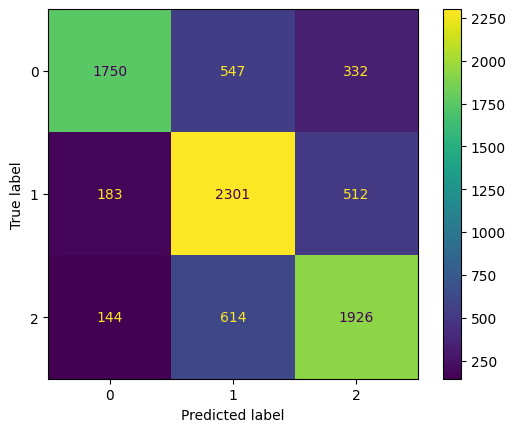

In [22]:
print("F1-Score",f1_score(eval_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(eval_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(eval_labels,pred_labels,average='weighted'))
print("Accuracy-Score",accuracy_score(eval_labels,pred_labels))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_matrix = tf.math.confusion_matrix(eval_labels,pred_labels,num_classes=3)
print(confusion_matrix)
cmd = ConfusionMatrixDisplay(confusion_matrix.numpy())
cmd.plot()
# plt.show()

print("True Labels Onlys",tf.math.confusion_matrix(eval_labels,eval_labels,num_classes=3))

## Attention Score Visualization

In [28]:
## processing a text:
# tokens = tokenizer('विश्वमा महामारीको रुपमा फैलिरहेको कोरोना भाइरस(कोभिड–१९) को बारेमा विभिन्न भ्रामक समाचारहरु आइरहेका छन्',padding='max_length',max_length=128)['input_ids']
tokens = train_input[1]
context_size = len([0 for _ in tokens if _ != tokenizer.pad_token_id])

model(tf.constant([tokens]))
print("Actual Context Length",context_size)
print(tokenizer.convert_ids_to_tokens(tokens[:context_size]))

Actual Context Length 55
['[CLS]', 'बग', '##लर', '##बाट', 'विवाहको', 'लागि', 'घर', 'गएका', 'नायक', '##मा', 'जवर', '##ो', 'र', 'अन', '##य', 'लक', '##षण', 'द', '##खि', '##एपछि', 'परी', '##क', '##षण', 'गर', '##दा', 'को', '##भि', '##ड', 'सक', '##रमण', 'प', '##ष', '##टि', 'भएको', 'थियो', '।', 'अहि', '##ल', 'बह', '##ली', '##सहित', 'अन', '##य', 'परिवारको', 'पनि', 'को', '##भि', '##ड', 'परी', '##क', '##षण', 'गराइएको', 'छ', '।', '[SEP]']


### 1. Global Attentions

['[CLS]', 'बग', '##लर', '##बाट', 'विवाहको', 'लागि', 'घर', 'गएका', 'नायक', '##मा', 'जवर', '##ो', 'र', 'अन', '##य', 'लक', '##षण', 'द', '##खि', '##एपछि', 'परी', '##क', '##षण', 'गर', '##दा', 'को', '##भि', '##ड', 'सक', '##रमण', 'प', '##ष', '##टि', 'भएको', 'थियो', '।', 'अहि', '##ल', 'बह', '##ली', '##सहित', 'अन', '##य', 'परिवारको', 'पनि', 'को', '##भि', '##ड', 'परी', '##क', '##षण', 'गराइएको', 'छ', '।', '[SEP]']


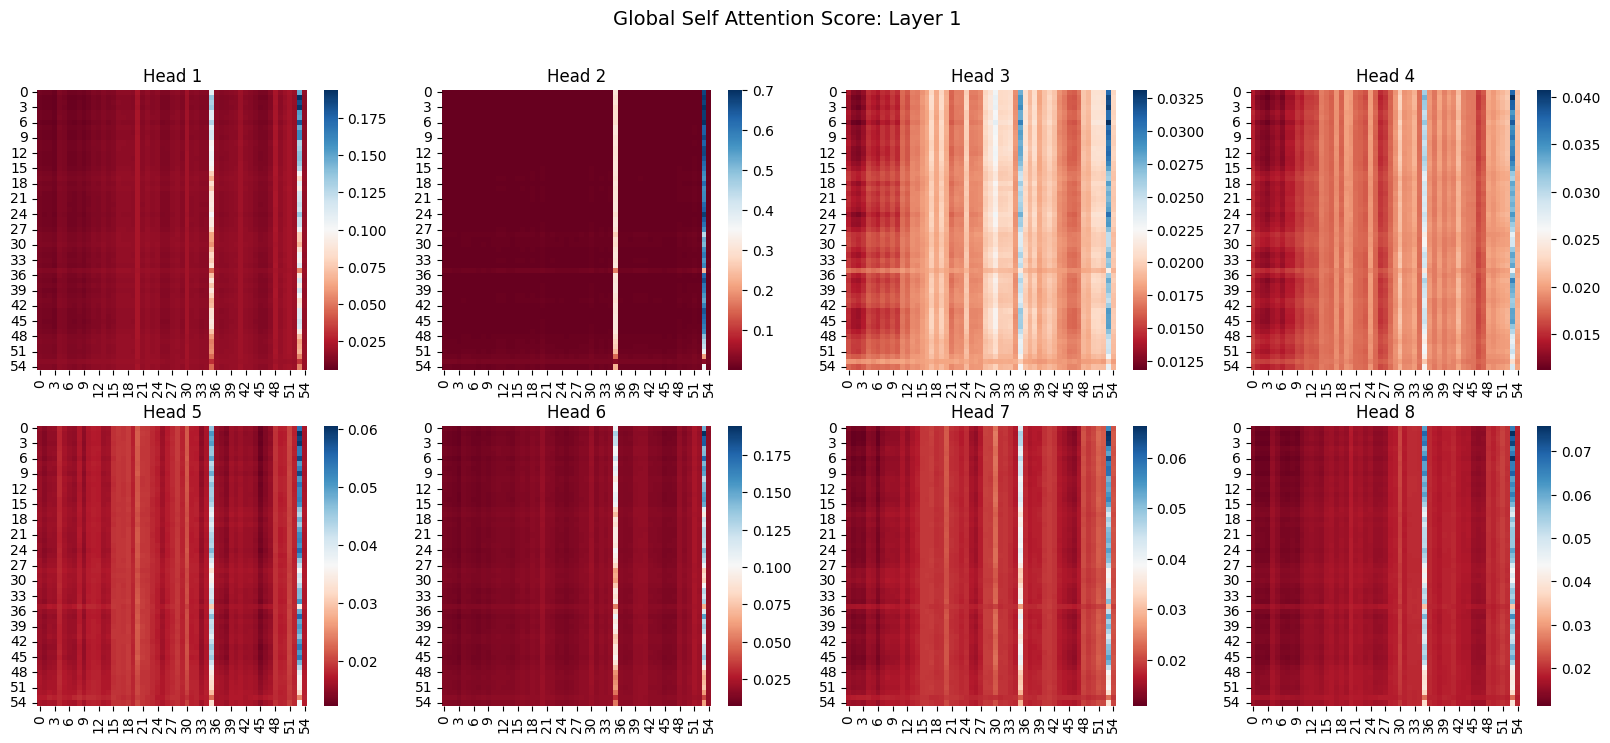

In [27]:
from matplotlib import pyplot as plt
import math
import seaborn as sns

nLayer = model.num_layers
nHead = model.encoder.gsa_enc_layers[0].self_attention.attention_score.shape[1] ## attention_score[nBatch][nHead]


cols = 4
rows= math.ceil(nHead/cols) if nHead > cols else 1
for i in range(nLayer):
  fig = plt.figure(figsize=[5*cols, 4*rows])
  fig.suptitle('Global Self Attention Score: Layer {}'.format(i+1), fontsize=14)
  index = 1
  for j in range(nHead):
    ax = fig.add_subplot(rows,cols,index)
    ax.set_title("Head {}".format(j+1))
    sns.heatmap(model.encoder.gsa_enc_layers[i].self_attention.attention_score[0][j][:context_size,:context_size],ax=ax,cmap="RdBu")
    index+=1
  plt.show()


Per Window Context Length:  16


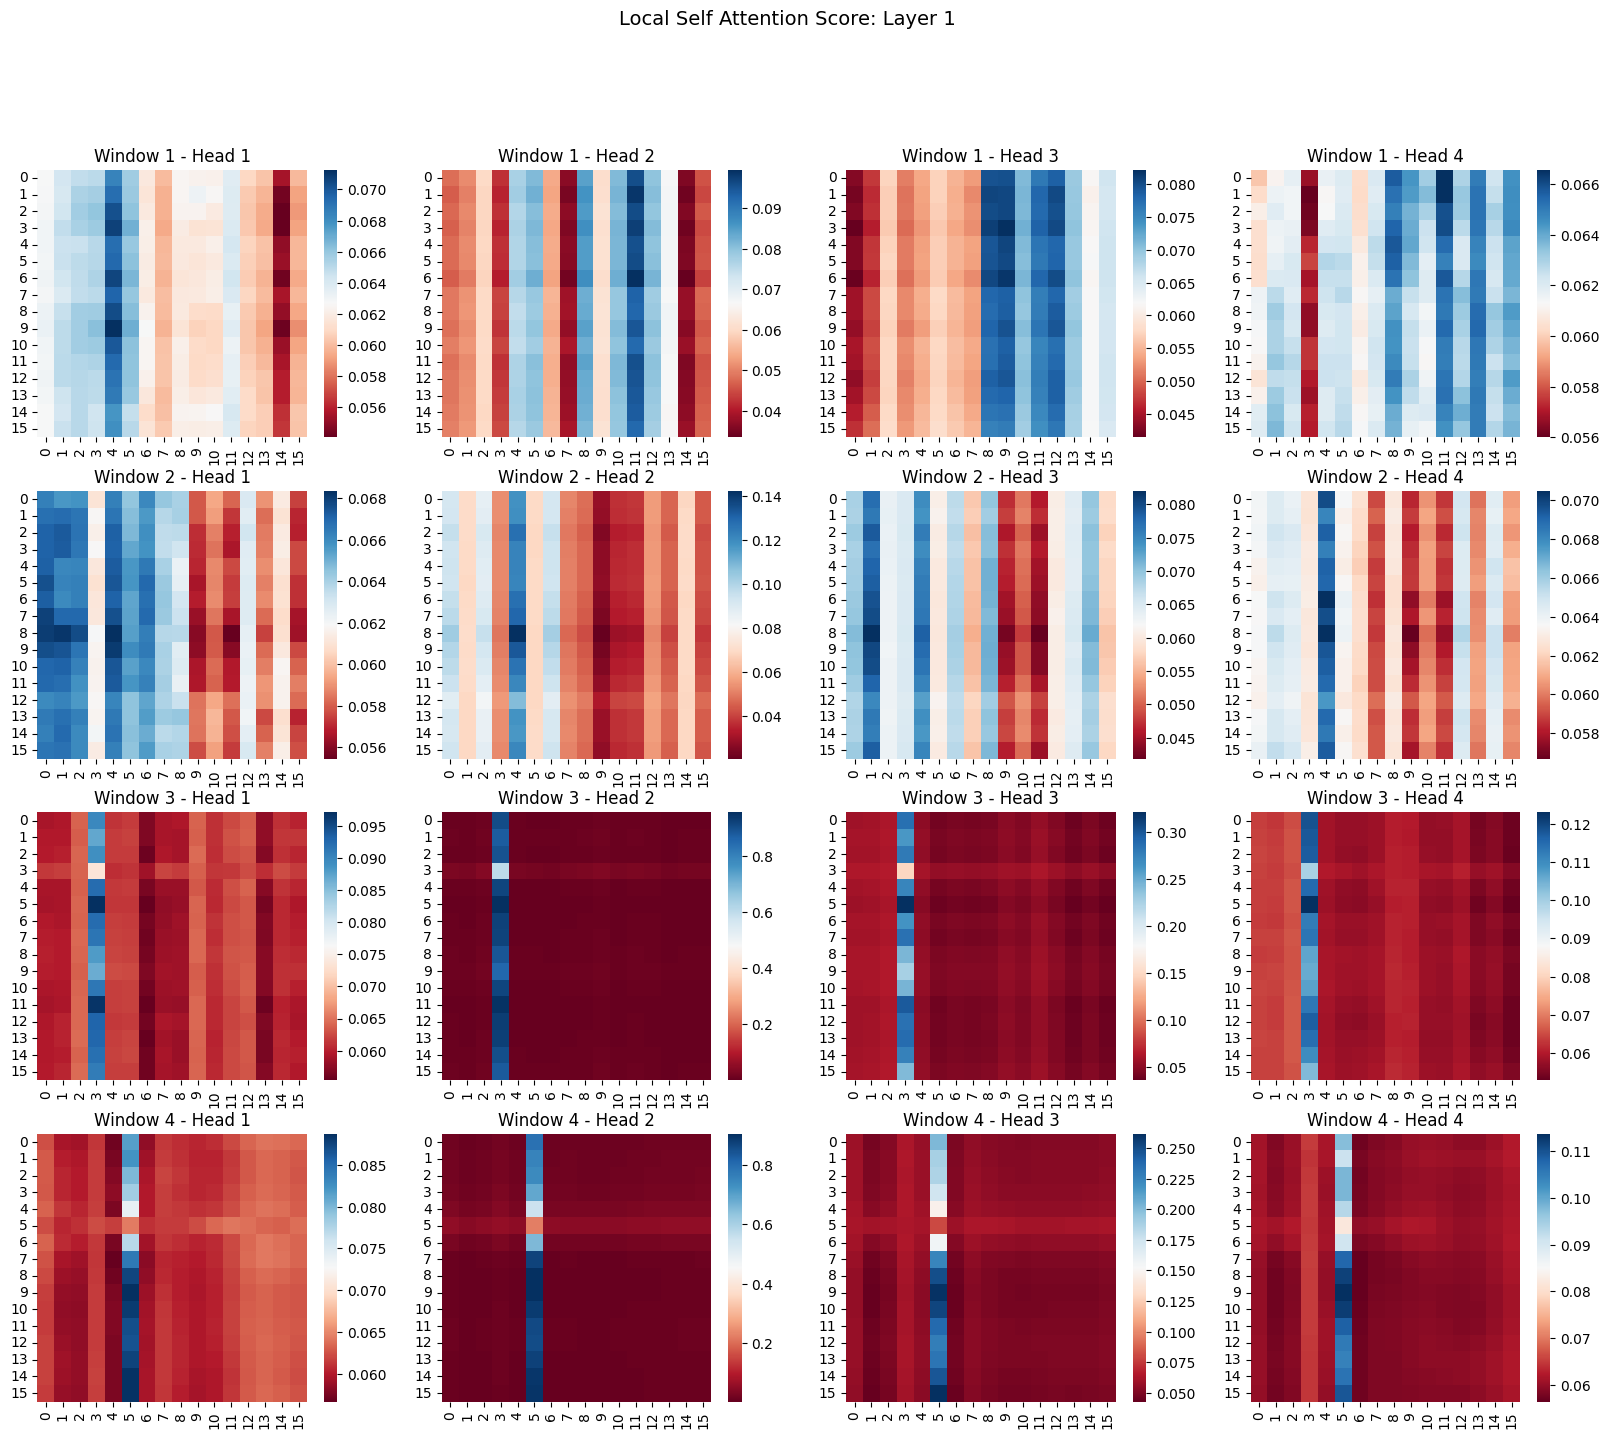

In [29]:
per_window_context = model.encoder.lsa_enc_layers[0].self_attention.attention_score[0].shape[-1]

nWindow = 1 if per_window_context >= context_size else context_size//per_window_context + 1   #len(model.encoder.lsa_enc_layers[0].self_attention.attention_score)
nHead = model.encoder.lsa_enc_layers[0].self_attention.attention_score[0].shape[1]  ## attention_score[nWindow][nBatch]

print("Per Window Context Length: ",per_window_context)

rows = math.ceil((nHead*nWindow)/cols) if (nHead*nWindow) > cols else 1
for i in range(nLayer):
  fig = plt.figure(figsize=[5*cols, 4*rows])
  fig.suptitle('Local Self Attention Score: Layer {}'.format(i+1), fontsize=14)
  index = 1
  for j in range(nWindow):
    for k in range(nHead):
      ax = fig.add_subplot(rows,cols,index)
      ax.set_title("Window {} - Head {}".format(j+1,k+1))
      sns.heatmap(model.encoder.lsa_enc_layers[i].self_attention.attention_score[j][0][k],ax=ax,cmap="RdBu")
      index+=1
  plt.show()